#### Informer reference blog: <a href="https://huggingface.co/blog/informer">Link</a>

Working Notebook : <a href="https://github.com/huggingface/notebooks/blob/main/examples/multivariate_informer.ipynb">Link</a>
Medium Link : <a href="https://rezayazdanfar.medium.com/informer-beyond-efficient-transformer-for-long-sequence-time-series-forecasting-4eeabb669eb">Link</a>

In [1]:
!pip install -q holoviews==1.18.1
!pip install -q pandarallel==1.6.5
!pip install -q gluonts==0.14.3
!pip install -q datasets==2.16.1
!pip install -q accelerate==0.26.1
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 39.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.8 MB/s eta 0:00:00


In [2]:
import time
import pandas as pd
import numpy as np
import math
import torch
import datasets
import pickle
import itertools


from datetime import datetime
from pandarallel import pandarallel
from pandas.core.arrays.period import period_array
from functools import lru_cache, partial
import matplotlib.pyplot as plt

from datetime import datetime
from datasets import load_dataset, Dataset
from transformers import InformerConfig, InformerForPrediction
from torch import nn

from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.time_feature import get_lags_for_frequency
from gluonts.time_feature import time_features_from_frequency_str


from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)
from transformers import PretrainedConfig
from gluonts.transform.sampler import InstanceSampler
from typing import Optional
from typing import Iterable


from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches
# from accelerate import Accelerator
from torch.optim import AdamW


pandarallel.initialize(progress_bar=True)

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
from google.colab import drive

drive.mount("/content/drive")


Mounted at /content/drive


In [4]:
read_path = "drive/MyDrive/"
write_path = "drive/MyDrive/"
file_name = "1_3548C1.csv"
# df = pd.read_csv(read_path+file_name)
# df

In [ ]:
# df = df[(df["year"]<2021) | ((df["year"]==2021) & (df["month"]<=7) )]
# df

In [5]:
sensors=["KA60110","KA60120", "KA60190", "KA60220", "KA60250", "KA60260", "TH00186"]
#sensors=["KA60120", "KA60190", "KA60250", "KA60260", "TH00186"]

In [6]:
def format_date(dt, date_format = '%Y-%m-%d %H:%M:%S'):
  output = datetime.now()
  try:
    dt = dt.strip()
    output = datetime.strptime(dt, date_format)
  except Exception as ex:
    print(f"Error while formating date: {ex}")
  return output

#### Code changes
<ul>
    <li>Modify normalizing as per the sensor data</li>
    <li>Update <b>Maximum Value & Minimum Value</b> based of <b>Sensor</b> based on the <b>Amplifier</b></li>
    <li>Make more changes as per the requirements</li>
</ul>

In [7]:
class CleanData:
    """
    Cleaning the data
    """

    def __init__(self, path, sensors):
        """
        initializing the class with csv path and input sensors
        """
        try:
            start = time.time()
            self.df = None
            self.sensors = sensors
            if path is not None and len(path) > 0:
                self.df = pd.read_csv(path)
                print(f"Time taken to read data: {time.time() - start}")
        except Exception as ex:
            print(f"Error while intializing dataframe data: {ex}")

    def format_date(self, dt, date_format='%Y-%m-%d %H:%M:%S'):
        output = datetime.now()
        try:
            dt = dt.strip()
            output = datetime.strptime(dt, date_format)
        except Exception as ex:
            print(f"Error while formating date: {ex}")
        return output

    def clean_data(self):
        """
        ETL operations modify as per the requirements
        """
        try:
            start = time.time()

            # self.df.drop(columns=["Unnamed: 0"],inplace=True)
            columns = list(self.df.columns)
            if columns:
                for col in columns:
                    if col.startswith("Unnamed"):
                        self.df.drop(columns=[col], inplace=True)
            self.df.rename(columns={"dt": "date"}, inplace=True)
            self.df.dropna(inplace=True)
            self.df["date_format"] = self.df["date"].parallel_apply(lambda x: format_date(x))
            self.df["year"] = self.df["date_format"].parallel_apply(lambda x: x.year)
            self.df["month"] = self.df["date_format"].parallel_apply(lambda x: x.month)
            self.df = self.df[(self.df["year"] < 2021) | ((self.df["year"] == 2021) & (self.df["month"] <= 7))]
            print(f"Time taken to clean data: {time.time() - start}")
        except Exception as ex:
            print(f"Error while cleaning data: {ex}")

    def normalize_data(self):
        """
        Normalizing the data please update once Maximum and minimum values are shared
        """
        try:
            start = time.time()
            for sensor in sensors:
                o = len(df[sensor].unique())
                if o > 2:
                    min_val = self.df[sensor].min()
                    max_val = self.df[sensor].max()
                    mean_val = self.df[sensor].mean()
                    std_val = self.df[sensor].std()
                    if min_val != max_val:
                        # sample_df[col] = sample_df[col].apply(lambda x: (x-mean_val)/std_val)
                        self.df[sensor] = self.df[sensor].apply(lambda x: (x - min_val) / (max_val - min_val))
                    elif min_val == max_val and min_val > 1:
                        self.df[sensor] = 1.0
            print(f"Time taken to normalize data: {time.time() - start}")
        except Exception as ex:
            print(f"Error while normalizing data: {ex}")

    def get_df(self, recs=None):
        try:
            if recs is None:
                return self.df
            else:
                return self.df[:recs]
        except Exception as ex:
            print(f"Error while cleaning data: {ex}")
        return self.df

    def update_df(self, df):
        try:
            self.df = df
        except Exception as ex:
            print(f"Error while cleaning data: {ex}")

##### Loading the data

In [8]:
%%time
cleaning_data = CleanData(read_path+file_name, sensors)
cleaning_data.clean_data()
df = cleaning_data.get_df()
df

Time taken to read data: 46.72422385215759


Time taken to clean data: 67.18534350395203
CPU times: user 46.7 s, sys: 9.24 s, total: 55.9 s
Wall time: 1min 53s


date    KA60110  KA60210  KA60220    KA60250  \
1         2014-01-01 00:00:16  5826.0386      1.0     20.0 -96.649601   
2         2014-01-01 00:00:32  5824.0425      1.0     20.0 -97.441934   
3         2014-01-01 00:00:48  5824.0425      1.0     20.0 -97.441934   
4         2014-01-01 00:01:04  5826.0386      1.0     20.0 -96.246569   
5         2014-01-01 00:01:20  5824.0425      1.0     20.0 -96.649601   
...                       ...        ...      ...      ...        ...   
14952595  2021-07-31 23:58:40  5692.2890      1.0     63.0  -0.916093   
14952596  2021-07-31 23:58:56  5692.2890      1.0     63.0  -1.518488   
14952597  2021-07-31 23:59:12  5692.2890      1.0     63.0  -1.518488   
14952598  2021-07-31 23:59:28  5692.2890      1.0     63.0  -2.114649   
14952599  2021-07-31 23:59:44  5692.2890      1.0     63.0  -0.916093   

            KA60260  KA60280   KA60120  KA60180   KA60190    TH00186  KA60100  \
1        -19.976585      7.0  0.156191      1.0  1.488716  25.091562      0.0   
2        -19.946287      7.0  0.156191      1.0  1.488716  25.091562      0.0   
3        -19.946287      7.0  0.156191      1.0  1.488716  26.486408      0.0   
4        -19.991996      7.0  0.156191      1.0  1.488716  26.016119      0.0   
5        -19.976585      7.0  0.156191      1.0  1.488716  25.551228      0.0   
...             ...      ...       ...      ...       ...        ...      ...   
14952595 -46.113248     15.0 -0.326036      1.0  0.015521  24.187254      1.0   
14952596 -46.077809     15.0 -0.326036      1.0  0.015521  23.742298      1.0   
14952597 -46.077809     15.0 -0.326036      1.0  0.015521  23.742298      1.0   
14952598 -46.042737     15.0 -0.326036      1.0  0.015521  23.301947      1.0   
14952599 -46.113248     15.0 -0.326036      1.0  0.015521  24.187254      1.0   

          KA60240         date_format  year  month  
1             1.0 2014-01-01 00:00:16  2014      1  
2             1.0 2014-01-01 00:00:32  2014      1  
3             1.0 2014-01-01 00:00:48  2014      1  
4             1.0 2014-01-01 00:01:04  2014      1  
5             1.0 2014-01-01 00:01:20  2014      1  
...           ...                 ...   ...    ...  
14952595      1.0 2021-07-31 23:58:40  2021      7  
14952596      1.0 2021-07-31 23:58:56  2021      7  
14952597      1.0 2021-07-31 23:59:12  2021      7  
14952598      1.0 2021-07-31 23:59:28  2021      7  
14952599      1.0 2021-07-31 23:59:44  2021      7  

[14952599 rows x 16 columns]

In [ ]:
# years = df["year"].unique()
# years

##### Selection of sample data for training

In [9]:
validation_df = df[df["year"]==2015]
cleaning_data.update_df(validation_df)
validation_df


date    KA60110  KA60210    KA60220     KA60250  \
1971000  2015-01-01 00:00:00  5824.0425      1.0  10.666667  -57.965919   
1971001  2015-01-01 00:00:16  5836.0200      1.0  22.000000 -103.982281   
1971002  2015-01-01 00:00:32  5836.0200      1.0  22.000000 -106.006486   
1971003  2015-01-01 00:00:48  5836.0200      1.0  22.000000 -103.982281   
1971004  2015-01-01 00:01:04  5836.0200      1.0  22.000000 -101.938621   
...                      ...        ...      ...        ...         ...   
3941995  2015-12-31 23:58:40  5846.0015      1.0  22.000000  -97.831524   
3941996  2015-12-31 23:58:56  5846.0015      1.0  22.000000  -98.216914   
3941997  2015-12-31 23:59:12  5846.0015      1.0  22.000000  -98.598235   
3941998  2015-12-31 23:59:28  5846.0015      1.0  22.000000  -97.831524   
3941999  2015-12-31 23:59:44  5846.0015      1.0  22.000000  -97.831524   

           KA60260  KA60280   KA60120  KA60180   KA60190    TH00186  KA60100  \
1971000 -20.908327      7.0  0.290143      1.0  3.667818  12.381700      0.0   
1971001 -20.390202      7.0  0.156191      1.0  1.626828  22.007118      0.0   
1971002 -20.913282      7.0  0.156191      1.0  1.603810  21.583817      0.0   
1971003 -20.908327      7.0  0.156191      1.0  1.603810  22.007118      0.0   
1971004 -20.385201      7.0  0.156191      1.0  1.603810  22.434488      0.0   
...            ...      ...       ...      ...       ...        ...      ...   
3941995 -20.953723      7.0  0.156191      1.0  1.603810  24.187254      0.0   
3941996 -20.418698      7.0  0.156191      1.0  1.603810  23.742298      0.0   
3941997 -20.403664      7.0  0.156191      1.0  1.626828  24.636957      0.0   
3941998 -20.433892      7.0  0.156191      1.0  1.626828  24.636957      0.0   
3941999 -20.433892      7.0  0.156191      1.0  1.603810  24.187254      0.0   

         KA60240         date_format  year  month  
1971000      0.0 2015-01-01 00:00:00  2015      1  
1971001      0.0 2015-01-01 00:00:16  2015      1  
1971002      0.0 2015-01-01 00:00:32  2015      1  
1971003      0.0 2015-01-01 00:00:48  2015      1  
1971004      0.0 2015-01-01 00:01:04  2015      1  
...          ...                 ...   ...    ...  
3941995      0.0 2015-12-31 23:58:40  2015     12  
3941996      0.0 2015-12-31 23:58:56  2015     12  
3941997      0.0 2015-12-31 23:59:12  2015     12  
3941998      0.0 2015-12-31 23:59:28  2015     12  
3941999      0.0 2015-12-31 23:59:44  2015     12  

[1971000 rows x 16 columns]

##### Normalizing the data

In [10]:
cleaning_data.normalize_data()
validation_df = cleaning_data.get_df()
validation_df

<ipython-input-7-1a81f92845cc>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[sensor] = self.df[sensor].apply(lambda x: (x-min_val)/(max_val-min_val))


Time taken to normalize data: 5.775247097015381


date    KA60110  KA60210    KA60220   KA60250  \
1971000  2015-01-01 00:00:00  5824.0425      1.0  10.666667  1.000000   
1971001  2015-01-01 00:00:16  5836.0200      1.0  22.000000  0.351934   
1971002  2015-01-01 00:00:32  5836.0200      1.0  22.000000  0.323426   
1971003  2015-01-01 00:00:48  5836.0200      1.0  22.000000  0.351934   
1971004  2015-01-01 00:01:04  5836.0200      1.0  22.000000  0.380716   
...                      ...        ...      ...        ...       ...   
3941995  2015-12-31 23:58:40  5846.0015      1.0  22.000000  0.438558   
3941996  2015-12-31 23:58:56  5846.0015      1.0  22.000000  0.433130   
3941997  2015-12-31 23:59:12  5846.0015      1.0  22.000000  0.427760   
3941998  2015-12-31 23:59:28  5846.0015      1.0  22.000000  0.438558   
3941999  2015-12-31 23:59:44  5846.0015      1.0  22.000000  0.438558   

          KA60260  KA60280   KA60120  KA60180   KA60190   TH00186  KA60100  \
1971000  0.066032      7.0  0.541667      1.0  1.000000  0.157283      0.0   
1971001  0.124202      7.0  0.125000      1.0  0.022059  0.752211      0.0   
1971002  0.065476      7.0  0.125000      1.0  0.011029  0.726048      0.0   
1971003  0.066032      7.0  0.125000      1.0  0.011029  0.752211      0.0   
1971004  0.124764      7.0  0.125000      1.0  0.011029  0.778626      0.0   
...           ...      ...       ...      ...       ...       ...      ...   
3941995  0.060936      7.0  0.125000      1.0  0.011029  0.886961      0.0   
3941996  0.121003      7.0  0.125000      1.0  0.011029  0.859459      0.0   
3941997  0.122691      7.0  0.125000      1.0  0.022059  0.914757      0.0   
3941998  0.119297      7.0  0.125000      1.0  0.022059  0.914757      0.0   
3941999  0.119297      7.0  0.125000      1.0  0.011029  0.886961      0.0   

         KA60240         date_format  year  month  
1971000      0.0 2015-01-01 00:00:00  2015      1  
1971001      0.0 2015-01-01 00:00:16  2015      1  
1971002      0.0 2015-01-01 00:00:32  2015      1  
1971003      0.0 2015-01-01 00:00:48  2015      1  
1971004      0.0 2015-01-01 00:01:04  2015      1  
...          ...                 ...   ...    ...  
3941995      0.0 2015-12-31 23:58:40  2015     12  
3941996      0.0 2015-12-31 23:58:56  2015     12  
3941997      0.0 2015-12-31 23:59:12  2015     12  
3941998      0.0 2015-12-31 23:59:28  2015     12  
3941999      0.0 2015-12-31 23:59:44  2015     12  

[1971000 rows x 16 columns]

In [11]:
del cleaning_data

##### Testing on Sample dataset

In [12]:
validation_df = validation_df[validation_df["month"]==1]
validation_df.drop(columns=["month","year"],inplace=True)
validation_df

<ipython-input-12-2481f9c9c09e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df.drop(columns=["month","year"],inplace=True)


date    KA60110  KA60210    KA60220   KA60250  \
1971000  2015-01-01 00:00:00  5824.0425      1.0  10.666667  1.000000   
1971001  2015-01-01 00:00:16  5836.0200      1.0  22.000000  0.351934   
1971002  2015-01-01 00:00:32  5836.0200      1.0  22.000000  0.323426   
1971003  2015-01-01 00:00:48  5836.0200      1.0  22.000000  0.351934   
1971004  2015-01-01 00:01:04  5836.0200      1.0  22.000000  0.380716   
...                      ...        ...      ...        ...       ...   
2138395  2015-01-31 23:58:40  5836.0200      1.0  22.000000  0.267201   
2138396  2015-01-31 23:58:56  5836.0200      1.0  22.000000  0.239468   
2138397  2015-01-31 23:59:12  5836.0200      1.0  22.000000  0.267201   
2138398  2015-01-31 23:59:28  5836.0200      1.0  22.000000  0.267201   
2138399  2015-01-31 23:59:44  5836.0200      1.0  22.000000  0.267201   

          KA60260  KA60280   KA60120  KA60180   KA60190   TH00186  KA60100  \
1971000  0.066032      7.0  0.541667      1.0  1.000000  0.157283      0.0   
1971001  0.124202      7.0  0.125000      1.0  0.022059  0.752211      0.0   
1971002  0.065476      7.0  0.125000      1.0  0.011029  0.726048      0.0   
1971003  0.066032      7.0  0.125000      1.0  0.011029  0.752211      0.0   
1971004  0.124764      7.0  0.125000      1.0  0.011029  0.778626      0.0   
...           ...      ...       ...      ...       ...       ...      ...   
2138395  0.064379      7.0  0.125000      1.0  0.011029  0.674446      0.0   
2138396  0.063838      7.0  0.125000      1.0  0.011029  0.648993      0.0   
2138397  0.122549      7.0  0.125000      1.0  0.011029  0.674446      0.0   
2138398  0.122549      7.0  0.125000      1.0  0.011029  0.674446      0.0   
2138399  0.122549      7.0  0.125000      1.0  0.022059  0.674446      0.0   

         KA60240         date_format  
1971000      0.0 2015-01-01 00:00:00  
1971001      0.0 2015-01-01 00:00:16  
1971002      0.0 2015-01-01 00:00:32  
1971003      0.0 2015-01-01 00:00:48  
1971004      0.0 2015-01-01 00:01:04  
...          ...                 ...  
2138395      0.0 2015-01-31 23:58:40  
2138396      0.0 2015-01-31 23:58:56  
2138397      0.0 2015-01-31 23:59:12  
2138398      0.0 2015-01-31 23:59:28  
2138399      0.0 2015-01-31 23:59:44  

[167400 rows x 14 columns]

#### Please fix this part
Due to the frequency issues haven't updated. Please feel free to debug and fix this

In [13]:
validation_df["date"] = "2015-01-01 00:00:00"

<ipython-input-13-94bca514386f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df["date"] = "2015-01-01 00:00:00"


### Intializing the class to convert the data
Converting data to Dataset Fromat

In [14]:
class DatasetsDataSplit:
    """
    This class is used to Convert into Datasets format
    """
    def __init__(self, df, sensors):
        self.df = df
        self.sensors = sensors
        self.dataset = None

    def convert_to_Dataset(self, df, date_col="date", window=240):
        """
        This method is used to convert into Dataset required input format
        """
        try:
            start = time.time()
            start = time.time()
            time_stamp = df[date_col].values.tolist()
            time_stamp = [format_date(t) for t in time_stamp]
            cols = list(df.columns)
            cols.remove(date_col)
            row_len, col_len = df.shape
            vector_data = df[cols].values.tolist()
            complete_data = []
            i = 0
            for d in vector_data[:(-1) * window]:
                vector_window = vector_data[i:i + window]
                vector_window = list(itertools.chain.from_iterable(vector_window))
                complete_data.append(vector_window)
                i += 1

            time_stamp = time_stamp[:(-1) * (window)]
            row_len -= window
            output = {"start": time_stamp, "target": complete_data,  #sample_df[cols].values.tolist(),
                      "feat_static_cat": [[0] for i in range(row_len)],
                      "feat_dynamic_real": [None] * row_len, "item_id": ["T" + str(k) for k in range(row_len)]}
            print(f"Time taken to convert to Dataset format: {time.time() - start}")
            return output
        except Exception as ex:
            print(f"Error while converting to Dataset: {ex}")
        return None

    def get_data_spliter(self, start, end, window=240):
        """
        This method is used to create Datasets
        """
        try:
            s = time.time()
            out = self.convert_to_Dataset(self.df[self.sensors].iloc[start:end], window=window)
            if out is not None:
                start = time.time()
                self.data_set = Dataset.from_dict(out)
                print(f"Time taken to create dataset: {time.time() - start}")
            print(f"Total time taken: {time.time() - s}")
            return self.data_set
        except Exception as ex:
            print(f"Error while creating dataset")
        return None

    def check_data(self):
        """
        Checking the dataset target size
        """
        try:
            all_d = set()
            for d in self.data_set:
                all_d.add(len(d["target"]))
            return all_d
        except Exception as ex:
            print(f"Error while validate the target variable")

##### Date should be added to sensors

In [15]:
create_data = DatasetsDataSplit(validation_df, sensors+["date"])

##### Choose the sample to experiment as well time window
Input for get_data_spliter:
<ul>
    <li><b>tarin_start</b> and <b>train_end</b> are <b>df.iloc[tarin_start:train_end]</b> where df is dataframe</li>
    <li><b>time_window</b>: Number of minutes of time window we want to merge into single record or rows</li>
    <li><b>train_dataset</b>: shows number of rows and featurues</li>
    <li>target is which has all our features</li>
</ul>

output
<ul>
    <li><b>start</b>: Timestamp</li>
    <li><b>target</b>: Feature vector, Currently taking the time series of various features in the list and giving lag sequence</li>
    <li><b>item_id</b>: Item Id is unique for each of them</li>
<ul>

In [16]:
train_start = 0
train_end = 10000
time_window = 90
train_dataset = create_data.get_data_spliter(train_start, train_end, window=time_window)
train_dataset

Time taken to convert to Dataset format: 0.21008062362670898
Time taken to create dataset: 0.4220752716064453
Total time taken: 0.6365268230438232


Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 9910
})

##### Checking the dataset target dimensions

In [17]:
create_data.check_data()

{450}

Need to be addressed this if clients wants to proceed 
We need to only <b>sample set should be considered for prediction</b>, shouldn't be considered as number of rows in train_dataset
<ul>
    <li>Consider data post train_dataset</li>
    <li>This is un-seen data</li>
    <li>Code needs to be fixed</li>
    <li>Modify <b>val_end</b> such that rows are equal to <b>train_dataset</b></li>
</ul>

In [18]:
val_start = train_end
val_end = val_start+int(train_end*0.1)
val_end = val_start+10020 #+int(train_end*0.1)
time_window = 110
validation_dataset = create_data.get_data_spliter(val_start, val_end, window=time_window)
validation_dataset

Time taken to convert to Dataset format: 0.0219113826751709
Time taken to create dataset: 0.03381800651550293
Total time taken: 0.05997657775878906


Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 890
})

In [19]:
create_data.check_data()

{550}

##### Currently taking equal number of samples from train and test need to fix it
Need to be addressed this if clients wants to proceed 
We need to only <b>sample set should be considered for prediction</b>, shouldn't be considered as number of rows in train_dataset
<ul>
    <li>Consider data post train_dataset</li>
    <li>This is un-seen data</li>
    <li>Code needs to be fixed</li>
    <li>Modify <b>test_end</b> such that rows are equal to <b>train_dataset</b></li>
</ul>

In [20]:
test_start = val_end
test_end = val_end+int(train_end*0.1)
test_end = val_end+10020 #+int(train_end*0.1)
time_window = 110
test_dataset = create_data.get_data_spliter(test_start, test_end, window=time_window)
test_dataset

Time taken to convert to Dataset format: 0.23534178733825684
Time taken to create dataset: 0.43636631965637207
Total time taken: 0.6761090755462646


Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 9910
})

In [21]:
del create_data

In [22]:
len(train_dataset[0]["target"])

450

In [23]:
len(validation_dataset[0]["target"])

550

##### Updating the frequency and prediction length or next possible outputs

It would predict next 100 values of sequence post the input sequence

In [24]:
freq = "1H"
prediction_length = len(test_dataset[0]["target"])-len(train_dataset[0]["target"])
prediction_length

100

In [25]:
train_example = train_dataset[0]
assert len(train_example["target"]) + prediction_length == len(
    test_dataset[0]["target"]
)

In [ ]:
# import matplotlib.pyplot as plt

# num_of_samples = 150

# figure, axes = plt.subplots()
# axes.plot(validation_dataset[0]["target"][-num_of_samples:], color="blue")
# axes.plot(
#     validation_dataset[0]["target"][-num_of_samples - prediction_length :],
#     color="red",
#     alpha=0.5,
# )

# plt.show()

##### Converting into pandas dataframe

In [26]:
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

##### Transforming wrt the frequency

In [27]:
train_dataset.set_transform(partial(transform_start_field, freq=freq))

In [28]:
test_dataset.set_transform(partial(transform_start_field, freq=freq))

##### Creating the MultivariateGrouper

In [29]:
num_of_variates = len(train_dataset)
train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
multi_variate_train_dataset = train_grouper(train_dataset)


In [30]:
test_grouper = MultivariateGrouper(
    max_target_dim=len(test_dataset),
    # num_test_dates=1, # number of rolling test windows
)
multi_variate_test_dataset = test_grouper(test_dataset)

##### Checking the dataset

In [31]:
multi_variate_train_example = multi_variate_train_dataset[0]
print('multi_variate_train_example["target"].shape =', multi_variate_train_example["target"].shape)
multi_variate_test_example = multi_variate_test_dataset[0]
print('multi_variate_test_example["target"].shape =', multi_variate_test_example["target"].shape)

multi_variate_train_example["target"].shape = (9910, 450)
multi_variate_test_example["target"].shape = (9910, 550)


In [32]:
print(f'Training:\n train_dataset target size: {len(train_dataset[0]["target"])}\n Multivariate data target size: {len(multi_variate_train_dataset[0]["target"][0])}')
print(f'Testing:\n test_dataset target size: {len(test_dataset[0]["target"])}\n Multivariate data target size: {len(multi_variate_test_dataset[0]["target"][0])}')

Training:
 train_dataset size: 450
 Multivariate data size: 450
Testing:
 test_dataset size: 550
 Multivariate data size: 550


In [33]:
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 23, 24, 25, 47, 48, 49, 71, 72, 73, 95, 96, 97, 119, 120, 121, 143, 144, 145, 167, 168, 169, 335, 336, 337, 503, 504, 505, 671, 672, 673, 719, 720, 721]


##### Updated as per the number of features
As I have 5 features updated wrt that data

In [34]:
lags_sequence = [i*len(sensors) for i in range(1,10)]
lags_sequence

[5, 10, 15, 20, 25, 30, 35, 40, 45]

#### Time feature to consider

In [36]:
time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function hour_of_day at 0x7bd39dadfac0>, <function day_of_week at 0x7bd39dadfbe0>, <function day_of_month at 0x7bd39dadfd00>, <function day_of_year at 0x7bd39dadfe20>]


#### Please check the configs
Feel free to optimize as per the resources: <a href="https://huggingface.co/docs/transformers/main/en/model_doc/informer">Link</a>
<ul>
    <li>encoder_layers</li>
    <li>decoder_layers</li>
    <li>encoder_attention_heads</li>
    <li>decoder_attention_heads</li>
    <li>etc</li>
</ul>

Please explore further hope they might add lot of value

In [37]:
config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    # lags_sequence=[1, 24 * 7],
    lags_sequence=lags_sequence,
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,

    # informer params:
    dropout=0.1,

    encoder_layers=6,
    # encoder_attention_heads=4,
    decoder_layers=2,
    # decoder_attention_heads=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
)

model = InformerForPrediction(config)

In [38]:
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )


In [39]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )


In [40]:
def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )


In [41]:
def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # we create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )


In [ ]:
# torch.cuda.empty_cache()

##### Defining the batch size and number of epochs for batch

In [42]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=32,
    num_batches_per_epoch=64,
    # num_workers=2,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=16,
)


In [43]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([32, 315, 5]) torch.FloatTensor
past_values torch.Size([32, 315, 9910]) torch.FloatTensor
past_observed_mask torch.Size([32, 315, 9910]) torch.FloatTensor
future_time_features torch.Size([32, 100, 5]) torch.FloatTensor
future_values torch.Size([32, 100, 9910]) torch.FloatTensor
future_observed_mask torch.Size([32, 100, 9910]) torch.FloatTensor


In [44]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [45]:
%%time
epochs = 25
loss_history = []

# accelerator = Accelerator()
# device = accelerator.device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

# model, optimizer, train_dataloader = accelerator.prepare(
#     model,
#     optimizer,
#     train_dataloader,
# )

model.train()
for epoch in range(epochs):
    start = time.time()
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )

        # https://discuss.huggingface.co/t/accelerator-backward-loss-never-done/33387/4
        loss = outputs.loss

        # Backpropagation
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(f"epoch num: {epoch+1} loss: {loss.item()}")

    print(f"Time taken for epoch: {epoch+1}",time.time() - start)

epoch num: 1 loss: 4041.956298828125
Time taken for epoch: 1 90.93928861618042
epoch num: 2 loss: -7574.62890625
Time taken for epoch: 2 86.18910622596741
epoch num: 3 loss: -16538.806640625
Time taken for epoch: 3 87.33886504173279
epoch num: 4 loss: -16675.533203125
Time taken for epoch: 4 87.98692655563354
epoch num: 5 loss: -19375.888671875
Time taken for epoch: 5 86.90559601783752
epoch num: 6 loss: -18691.712890625
Time taken for epoch: 6 86.57655143737793
epoch num: 7 loss: -21497.341796875
Time taken for epoch: 7 86.97991752624512
epoch num: 8 loss: -21469.556640625
Time taken for epoch: 8 86.30631899833679
epoch num: 9 loss: -20973.908203125
Time taken for epoch: 9 86.93247079849243
epoch num: 10 loss: -21695.1015625
Time taken for epoch: 10 87.27787184715271
epoch num: 11 loss: -21499.607421875
Time taken for epoch: 11 84.95349502563477
epoch num: 12 loss: -19690.3671875
Time taken for epoch: 12 87.24801826477051
epoch num: 13 loss: -22789.384765625
Time taken for epoch: 13 8

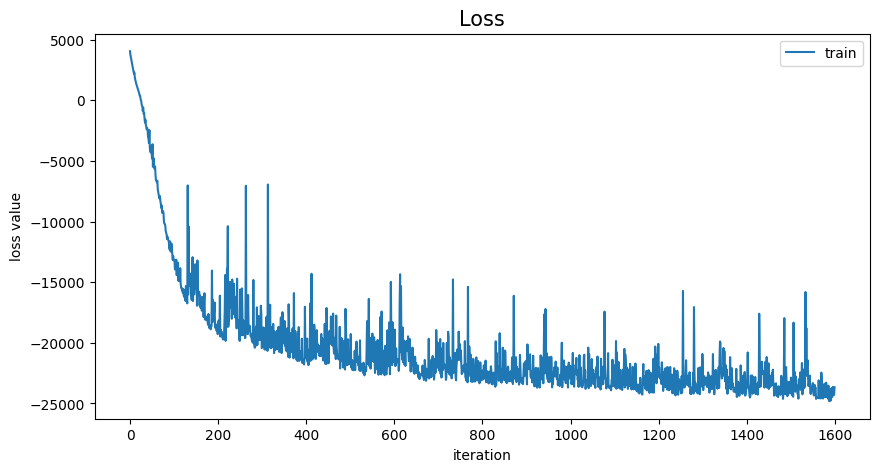

In [46]:
# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("loss value")
plt.show()


In [47]:
len(loss_history)

1600

In [48]:
model.eval()

forecasts_ = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

##### use the below cell in case of memory issues

In [ ]:
# import torch

# import gc
# torch.cuda.empty_cache()
# gc.collect()
# torch.cuda.empty_cache()

In [49]:
forecasts = np.vstack(forecasts_)
print(forecasts.shape)

(1, 100, 100, 9910)


In [50]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1).squeeze(0).T

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    # print(training_data)
    # print(ground_truth)
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        # periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

In [51]:
print(f"MASE: {np.mean(mase_metrics)}")
print(f"sMAPE: {np.mean(smape_metrics)}")

MASE: 0.22657874834191388
sMAPE: 0.5594033415470925


In [52]:
import matplotlib.dates as mdates


def plot(ts_index, mv_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=multi_variate_test_dataset[ts_index][FieldName.START],
        periods=len(multi_variate_test_dataset[ts_index][FieldName.TARGET]),
        freq=multi_variate_test_dataset[ts_index][FieldName.START].freq,
    ).to_timestamp()

    ax.xaxis.set_minor_locator(mdates.HourLocator())

    ax.plot(
        index[-2 * prediction_length :],
        multi_variate_test_dataset[ts_index]["target"][mv_index, -2 * prediction_length :],
        label="actual",
    )

    ax.plot(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(axis=0),
        label="mean",
    )
    ax.fill_between(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(0)
        - forecasts[ts_index, ..., mv_index].std(axis=0),
        forecasts[ts_index, ..., mv_index].mean(0)
        + forecasts[ts_index, ..., mv_index].std(axis=0),
        alpha=0.2,
        interpolate=True,
        label="+/- 1-std",
    )
    ax.legend()
    fig.set_figheight(12)
    fig.set_figwidth(20)
    fig.autofmt_xdate()

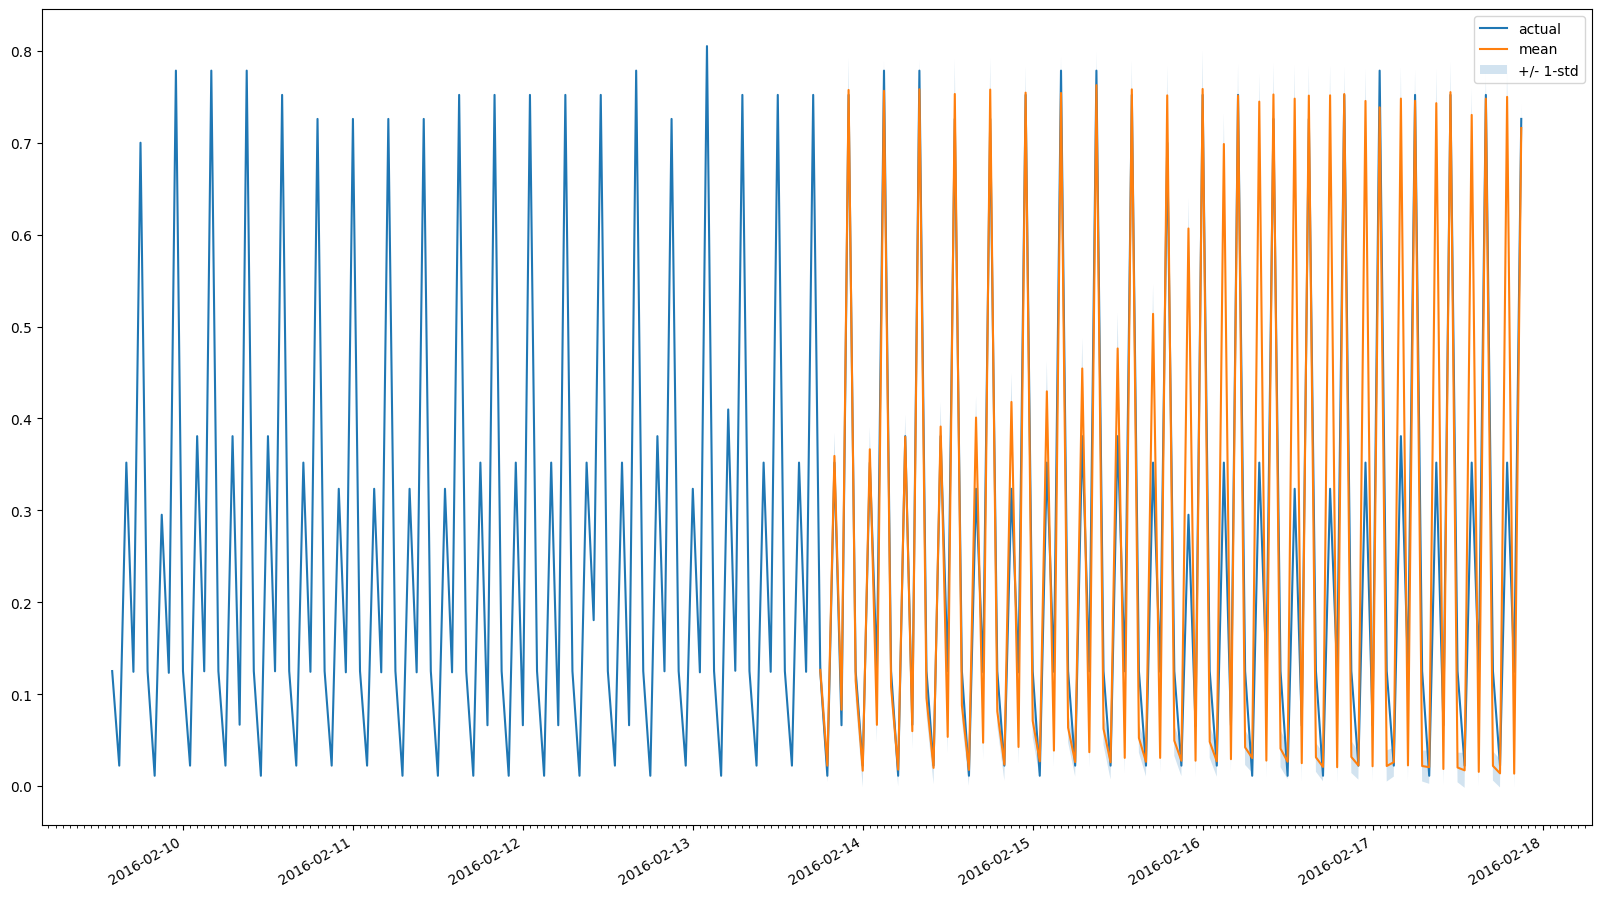

In [53]:
plot(0, 0)

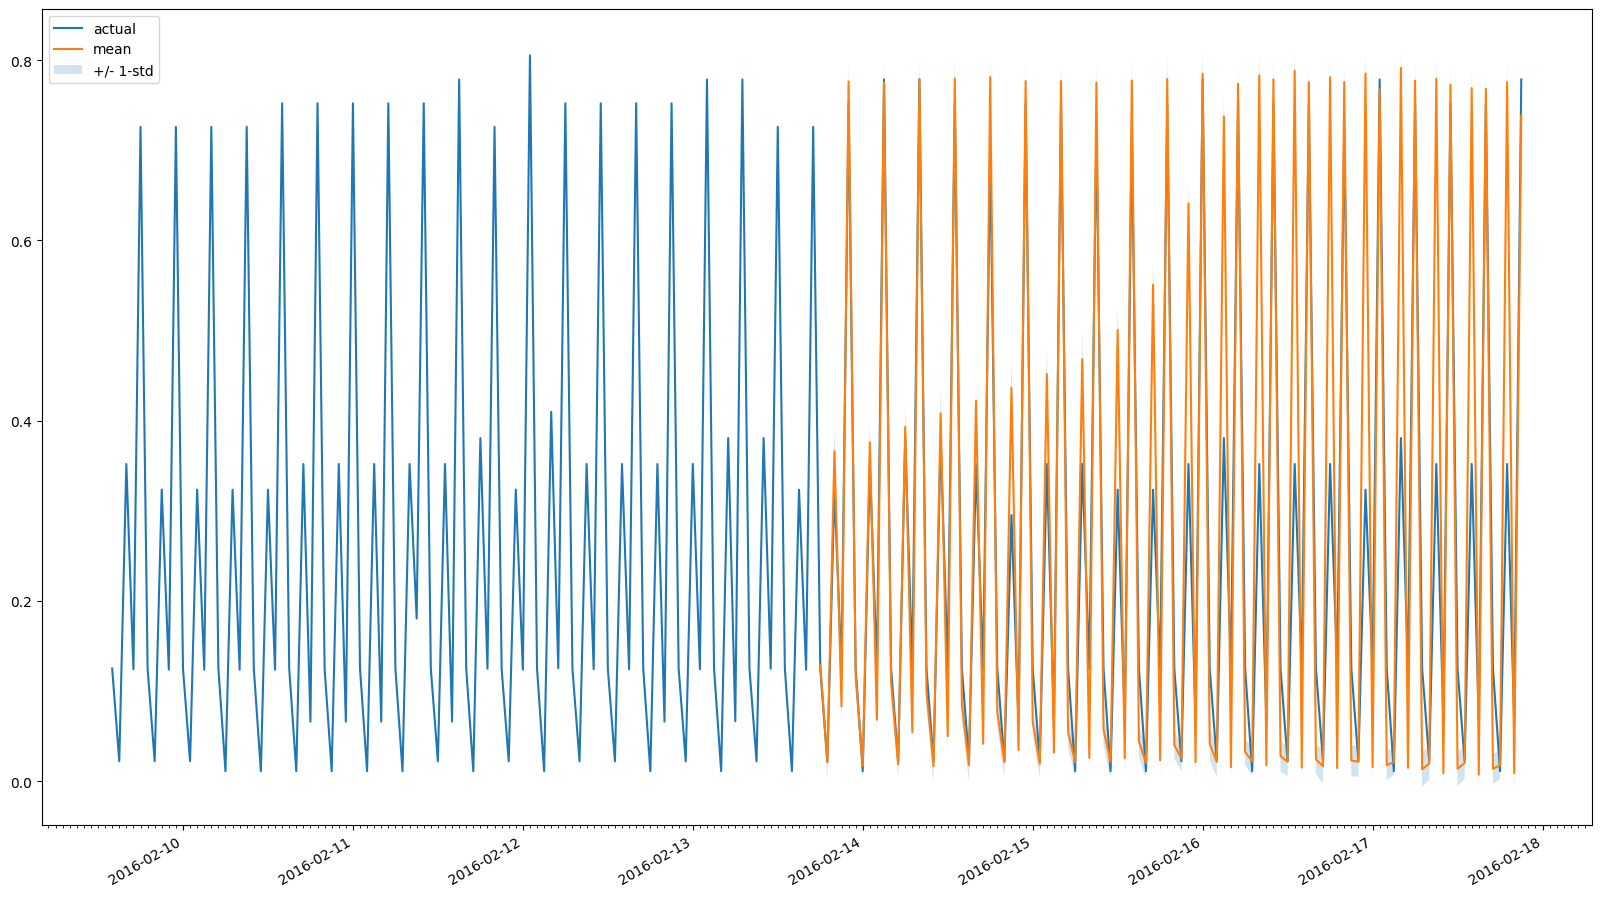

In [54]:
plot(0, 5)